# **Семинар 13.** Generative Adversarial Network (GAN)

В этом семинаре мы реализуем и обучим генеративно-состязательную сеть для генерации изображений. 

[[Оригинальная статья](https://arxiv.org/pdf/1406.2661)]


In [1]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchvision.datasets import MNIST
from torchvision.transforms import v2
from torchvision.utils import make_grid

from IPython.display import clear_output

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
transform = v2.Compose(
    (
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,)),
    )
)

dataset = MNIST(root="data", train=True, download=True, transform=transform)
print(f"{len(dataset) = }")

image, label = dataset[42]
print(f"{image.shape = }")

len(dataset) = 60000
image.shape = torch.Size([1, 28, 28])


In [4]:
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=8)

images, labels = next(iter(dataloader))
images.shape, labels.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [5]:
def imshow(image: np.ndarray | torch.Tensor) -> None:
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy(force=True)
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

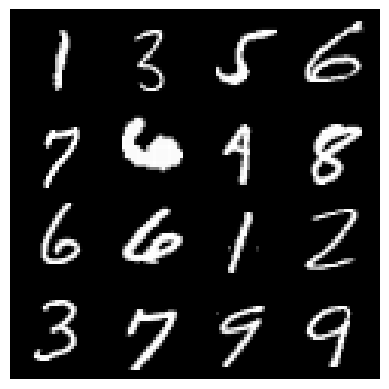

In [6]:
imshow(make_grid(images[:16], nrow=4, normalize=True))

### Генератор (Generator)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()

        self.latent_dim = latent_dim

In [8]:
class DigitGenerator(Generator):
    def __init__(self, latent_dim: int) -> None:
        super().__init__(latent_dim)

        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
            nn.Unflatten(-1, (1, 28, 28)),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.layers(z)


G = DigitGenerator(128)
z = torch.randn(8, 128)
G(z).shape

torch.Size([8, 1, 28, 28])

### Дискриминатор (Discriminator)

In [9]:
class Discriminator(nn.Module):
    pass

In [10]:
class DigitDiscriminator(Discriminator):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),
            nn.Linear(256, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x).squeeze()


D = DigitDiscriminator()
x = torch.randn(8, 1, 28, 28)
D(x).shape

torch.Size([8])

### Инициализация весов

In [11]:
def init_weights(module: nn.Module) -> None:
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(module.weight.data, 0.0, 0.02)

        if module.bias is not None:
            nn.init.zeros_(module.bias)

    elif isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d)):
        nn.init.normal_(module.weight, 1.0, 0.02)
        nn.init.zeros_(module.bias)

### Обучение

In [12]:
def train_gan(
    G: Generator,
    G_optimizer: torch.optim.Optimizer,
    D: Discriminator,
    D_optimizer: torch.optim.Optimizer,
    dataloader: DataLoader,
    max_epochs: int = 50,
    visualize_every_n_epochs: int = 5,
    device: str | torch.device = "cuda",
) -> tuple[list[float], list[float]]:
    G = G.to(device)
    D = D.to(device)

    # создаем шум, на котором будем визуально оценивать качество генерации
    fixed_z = torch.randn(64, G.latent_dim, device=device)

    G_loss_history: list[float] = []
    D_loss_history: list[float] = []

    for epoch in range(max_epochs):
        G.train()
        D.train()

        G_epoch_loss: list[float] = []
        D_epoch_loss: list[float] = []

        for real_images, *_ in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{max_epochs}", leave=False):
            B = real_images.shape[0]  # размер батча

            real_images = real_images.to(device)

            # создаем метки
            real_labels = torch.ones(B, device=device)
            fake_labels = torch.zeros(B, device=device)

            # === ОБУЧЕНИЕ DISCRIMINATOR ===
            D_optimizer.zero_grad()

            # функция потерь на реальных изображениях
            real_logits = D(real_images)
            D_loss_real = nn.functional.binary_cross_entropy_with_logits(real_logits, real_labels)

            # генерируем искусственные изображения
            z = torch.randn(B, G.latent_dim, device=device)
            fake_images = G(z)

            # функция потерь на сгенерированных изображениях
            fake_logits = D(fake_images.detach())  # используем .detach(), чтобы не обновлять генератор
            D_loss_fake = nn.functional.binary_cross_entropy_with_logits(fake_logits, fake_labels)

            D_loss = D_loss_real + D_loss_fake
            D_loss.backward()

            D_optimizer.step()

            # === ОБУЧЕНИЕ GENERATOR ===
            G_optimizer.zero_grad()

            # генерируем искусственные изображения
            z = torch.randn(B, G.latent_dim, device=device)
            fake_images = G(z)
            fake_logits = D(fake_images)

            # пытаемся обмануть дискриминатор
            G_loss = nn.functional.binary_cross_entropy_with_logits(fake_logits, real_labels)
            G_loss.backward()

            G_optimizer.step()

            G_epoch_loss.append(G_loss.item())
            D_epoch_loss.append(D_loss.item())

        G_loss_history.append(np.mean(G_epoch_loss))
        D_loss_history.append(np.mean(D_epoch_loss))

        # визуализация
        if (epoch + 1) % visualize_every_n_epochs == 0 or epoch == 0:
            clear_output(wait=True)
            print(f"Epoch [{epoch + 1}/{max_epochs}] | D Loss: {D_loss_history[-1]:.4f} | G Loss: {G_loss_history[-1]:.4f}")

            with torch.no_grad():
                G.eval()
                fake_images = G(fixed_z)

            grid = make_grid(fake_images, nrow=8, normalize=True)
            
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.axis("off")
            plt.title(f"Generated Images — Epoch {epoch + 1}")
            plt.show()

    # === КОНЕЦ ОБУЧЕНИЯ ===
    G.eval()
    D.eval()

    return G_loss_history, D_loss_history

In [13]:
digit_G = DigitGenerator(128)
digit_G.apply(init_weights)
digit_G_optimizer = torch.optim.Adam(digit_G.parameters(), lr=2e-4, betas=(0.5, 0.999))
print(f"Number of parameters in Generator:\t{sum(p.numel() for p in digit_G.parameters() if p.requires_grad):_}")

digit_D = DigitDiscriminator()
digit_D.apply(init_weights)
digit_D_optimizer = torch.optim.Adam(digit_D.parameters(), lr=2e-4, betas=(0.5, 0.999))
print(f"Number of parameters in Discriminator:\t{sum(p.numel() for p in digit_D.parameters() if p.requires_grad):_}")

Number of parameters in Generator:	1_495_312
Number of parameters in Discriminator:	533_505


Epoch [50/50] | D Loss: 1.3274 | G Loss: 0.8155


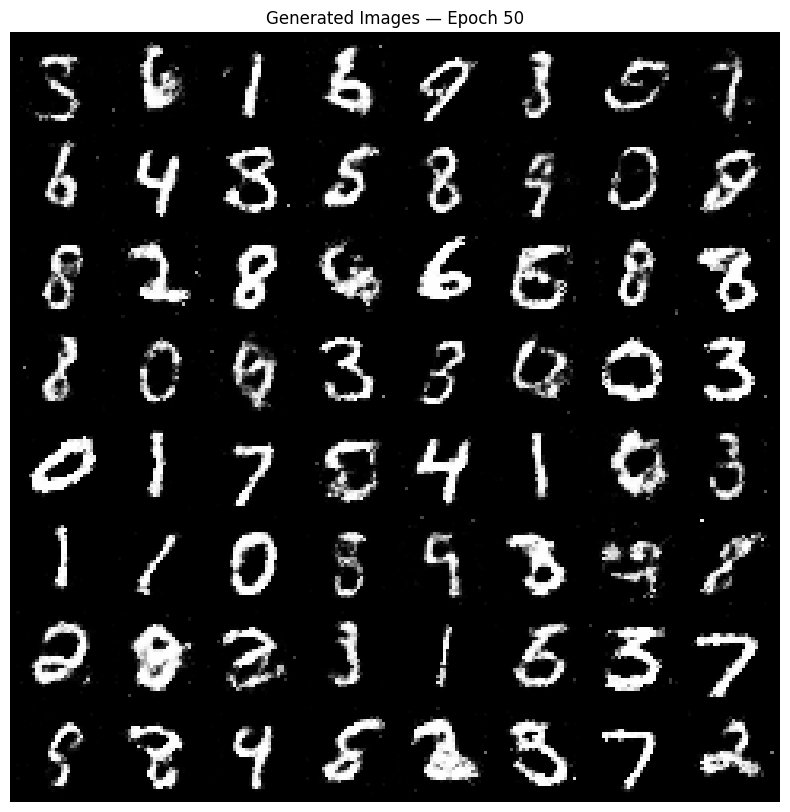

In [14]:
G_loss_history, D_loss_history = train_gan(
    digit_G,
    digit_G_optimizer,
    digit_D,
    digit_D_optimizer,
    dataloader,
    device=DEVICE,
)

### История обучения


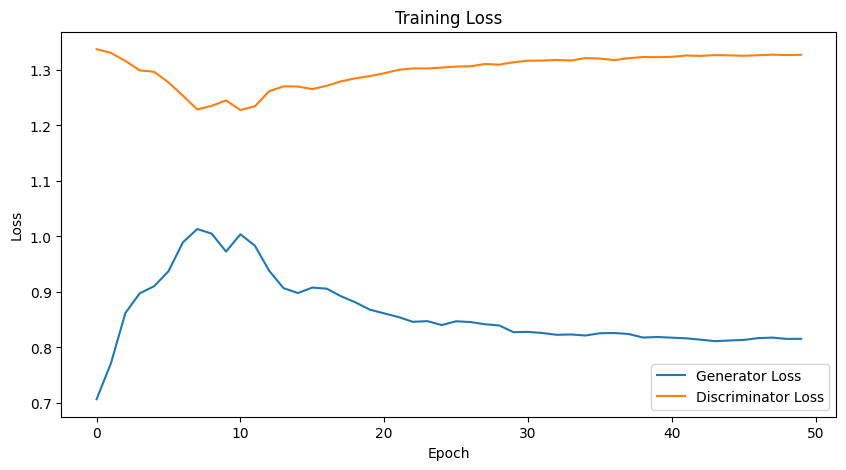

In [15]:
plt.figure(figsize=(10, 5))

plt.plot(G_loss_history, label="Generator Loss")
plt.plot(D_loss_history, label="Discriminator Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("Training Loss")

plt.show()

### Генерация новых изображений


In [16]:
def generate(G: Generator, num_images: int) -> None:
    G.eval()

    with torch.no_grad():
        z = torch.randn(num_images, G.latent_dim, device=DEVICE)
        generated_images = G(z)

    grid = make_grid(generated_images, nrow=8, normalize=True)

    plt.figure(figsize=(10, 10))

    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    plt.axis("off")
    plt.title("Generated Images")

    plt.show()

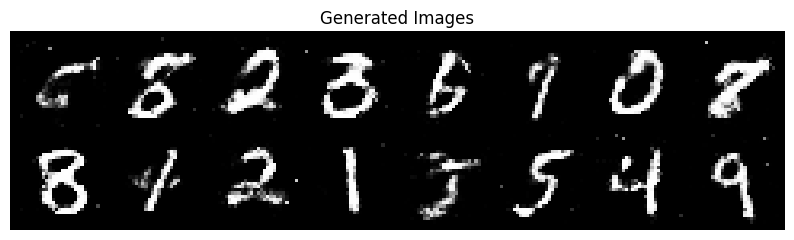

In [17]:
generate(digit_G, 16)

# Deep Convolutional GAN (DCGAN)

[[Оригинальная статья](https://arxiv.org/abs/1511.06434)]

In [18]:
# !kaggle datasets download -p data/ --unzip jessicali9530/lfw-dataset

In [19]:
def load_images(base_path: str) -> torch.Tensor:
    images = []

    for filepath in tqdm(sorted(Path(base_path).rglob("*.jpg")), desc="Loading images"):
        image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)

        height, width, _ = image.shape
        center = (height // 2, width // 2)
        image = cv2.getRectSubPix(image, (128, 128), center)
        
        images.append(image / 255)

    images = torch.from_numpy(np.stack(images)).permute(0, 3, 1, 2).float()
    return images

In [20]:
images = load_images(os.path.join("data", "lfw-deepfunneled"))
images.shape

Loading images: 100%|██████████| 13233/13233 [00:03<00:00, 3771.47it/s]


torch.Size([13233, 3, 128, 128])

In [21]:
class FaceDataset(TensorDataset):
    transform = v2.Compose(
        (
            v2.RandomRotation(15),
            v2.CenterCrop((64, 64)),
            v2.Normalize((0.5,), (0.5,)),
        )
    )

    def __getitem__(self, index: int) -> torch.Tensor:
        (image,) = super().__getitem__(index)
        return self.transform(image),


dataset = FaceDataset(images)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8)

images, *_ = next(iter(dataloader))
images.shape

torch.Size([128, 3, 64, 64])

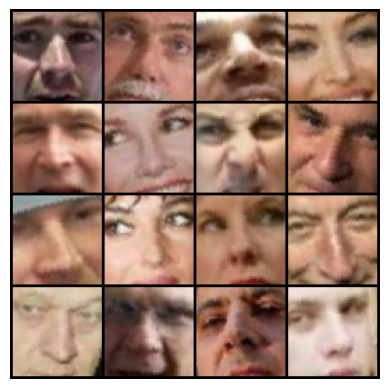

In [23]:
imshow(make_grid(images[:16], nrow=4, normalize=True))

In [24]:
class FaceGenerator(Generator):
    def __init__(self, latent_dim: int) -> None:
        super().__init__(latent_dim)

        self.layers = nn.Sequential(
            nn.Unflatten(-1, (latent_dim, 1, 1)),

            # (latent_dim, 1, 1) -> (512, 4, 4)
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=512, kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # (512, 4, 4) -> (256, 8, 8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # (256, 8, 8) -> (128, 16, 16)
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # (128, 16, 16) -> (64, 32, 32)
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # (64, 32, 32) -> (3, 64, 64)
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.layers(z)


G = FaceGenerator(128)
z = torch.randn(8, 128)
G(z).shape

torch.Size([8, 3, 64, 64])

In [25]:
class FaceDiscriminator(Discriminator):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            # (3, 64, 64) -> (64, 32, 32)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (64, 32, 32) -> (128, 16, 16)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # (128, 16, 16) -> (256, 8, 8)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # (256, 8, 8) -> (512, 4, 4)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # (512, 4, 4) -> (1, 1, 1)
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x).squeeze()


D = FaceDiscriminator()
x = torch.randn(8, 3, 64, 64)
D(x).shape

torch.Size([8])

In [26]:
face_G = FaceGenerator(128)
face_G.apply(init_weights)
face_G_optimizer = torch.optim.Adam(face_G.parameters(), lr=2e-4, betas=(0.5, 0.999))
print(f"Number of parameters in Generator:\t{sum(p.numel() for p in face_G.parameters() if p.requires_grad):_}")

face_D = FaceDiscriminator()
face_D.apply(init_weights)
face_D_optimizer = torch.optim.Adam(face_D.parameters(), lr=2e-4, betas=(0.5, 0.999))
print(f"Number of parameters in Discriminator:\t{sum(p.numel() for p in face_D.parameters() if p.requires_grad):_}")

Number of parameters in Generator:	3_806_083
Number of parameters in Discriminator:	2_765_569


Epoch [100/100] | D Loss: 0.3059 | G Loss: 4.0896


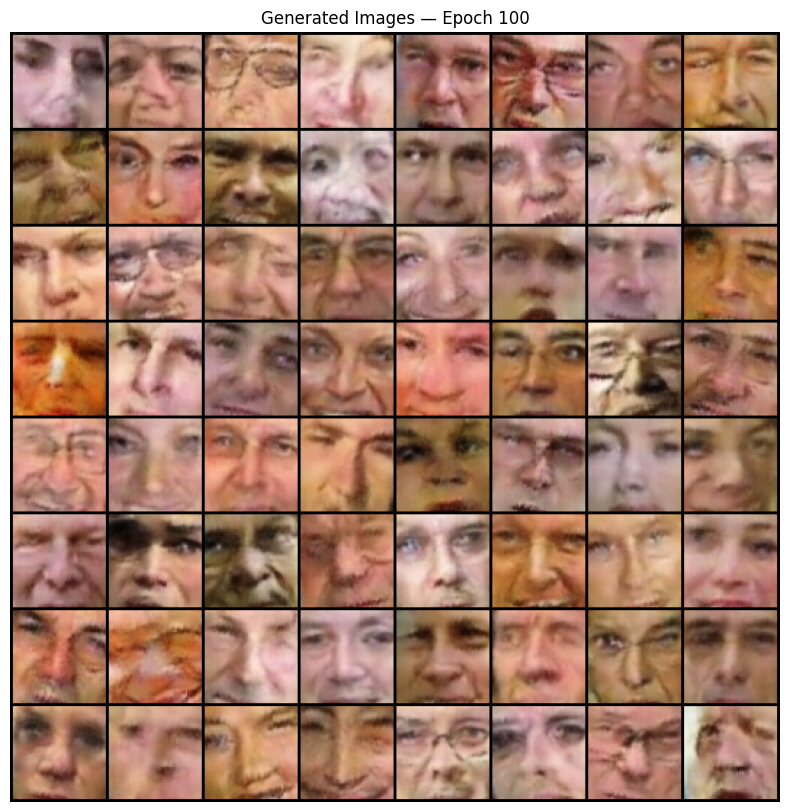

In [27]:
G_loss_history, D_loss_history = train_gan(
    face_G,
    face_G_optimizer,
    face_D,
    face_D_optimizer,
    dataloader,
    max_epochs=100,
    device=DEVICE,
)

### История обучения DCGAN


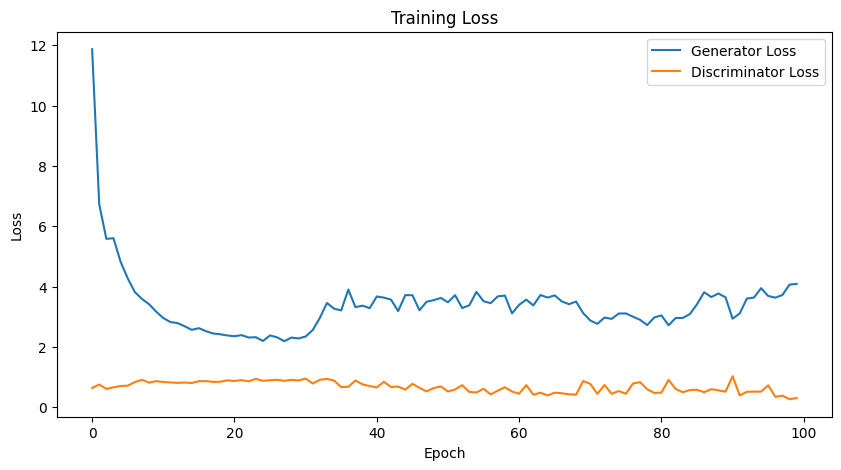

In [28]:
plt.figure(figsize=(10, 5))

plt.plot(G_loss_history, label="Generator Loss")
plt.plot(D_loss_history, label="Discriminator Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("Training Loss")

plt.show()

### Генерация новых лиц


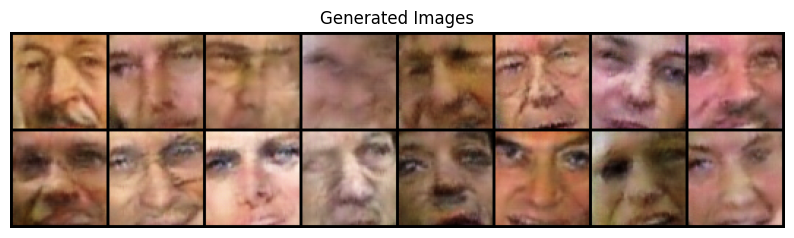

In [32]:
generate(face_G, 16)